# Comparing two models

In this tutorial we will examine how to properly compare two models given the available data.

The models that we will compare both consist of a *cosine* oscillation of angular frequency $\omega$ and $\phi$. Their difference is that in the **simple model, the total amplitude is a constant**, thus having:

$$
x_{\text{simple}}(t) = A\, \cos(\omega t + \phi)
$$

whereas in the **extended model the total amplitude is linearly-evolving with time**, thus having:

$$
x_{\text{extended}}(t) = (A+B\,t)\, \cos(\omega t + \phi)
$$

We begin by first importing the required packages, including of course ``pocoMC``:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pocomc as pc
np.random.seed(42)

## Defining the models and generating the data

We now can define both models as functions that accept an array of parameters and the time instances. We then generate the data using the *extended* model with the linearly-evolving amplitude by first specifying the true values of its parameters and then adding some Gaussian noise
to the model.

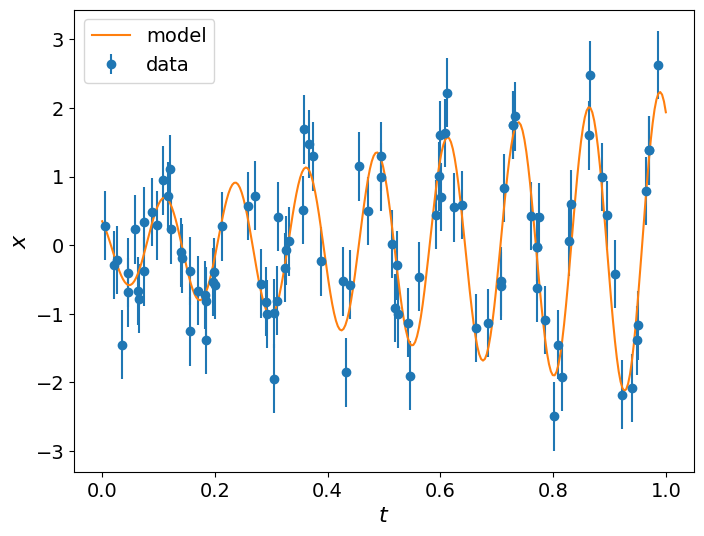

In [2]:
# Extended model with linearly-evolving amplitude
def model_extended(params, t):
    A, B, omega, phi, = params
    return (A + B * t) * np.cos(omega * t + phi)

# Simple model with constant amplitude
def model_simple(params, t):
    A, omega, phi, = params
    return A * np.cos(omega * t + phi)

# True parameters
params_true = np.array([0.5, 1.75, 50.0, 0.8])

# Time instances corresponding to available data
t = np.random.uniform(0.0, 1.0, 100)
idx = np.argsort(t)
t = t[idx]

# Standard deviation of Gaussian noise of the data
sigma = 0.5

# Simulated data
data = np.random.normal(model_extended(params_true, t), sigma) 

# Time range used for plotting only
t_range = np.linspace(0.0, 1.0, 300)

# Figure
plt.figure(figsize=(8,6))
plt.errorbar(t, data, yerr=sigma, fmt="o", label='data')
plt.plot(t_range, model_extended(params_true, t_range), label='model')
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$x$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Likelihood and Prior

We then define the log-likelihood function and prior object. We will use the same functions for both models and provide the model as an additional argument.

In [3]:
# Log-likelihood function used for either model
def log_like(params, t, data, sigma, model):
    m = model(params, t)
    diff = m - data
    return -0.5 * np.dot(diff, diff) / sigma**2.0


from scipy.stats import uniform

# Prior distributions for the parameters
# Extended model
prior_extended = pc.Prior([uniform(-5.0, 10.0), # A in [-5, 5]
                           uniform(-5.0, 10.0), # B in [-5, 5]
                           uniform(10.0, 90.0), # omega in [10, 100]
                           uniform(0.0, np.pi)]) # phi in [0, pi]

# Simple model
prior_simple = pc.Prior([uniform(-5.0, 10.0), # A in [-5, 5]
                         uniform(10.0, 90.0), # omega in [10, 100]
                         uniform(0.0, np.pi)]) # phi in [0, pi]

## Initialising and running Preconditioned Monte Carlo

Once we generate some initial positions for the particles by sampling from the prior we are ready to initialise the sampler and run PMC to get the results. We do this two times, once for the extended model and once for the simple model.

### Extended model

In [4]:
# Initialise sampler for extended model
sampler_extended = pc.Sampler(prior=prior_extended,
                              likelihood = log_like,
                              likelihood_args = [t, data, sigma, model_extended],
                              )

# Run sampler
sampler_extended.run()

# Get log evidence estimate
logz_extended, logz_err_extended = sampler_extended.evidence()

Iter: 38it [02:51,  4.52s/it, calls=32500, beta=1, logZ=-55.5, ESS=5.01e+3, accept=0.871, steps=1, logp=-46.3, efficiency=0.832]     


### Simple model

In [5]:
# Initialise sampler for simple model
sampler_simple = pc.Sampler(prior=prior_simple,
                              likelihood = log_like,
                              likelihood_args = [t, data, sigma, model_simple],
                              )

# Run sampler
sampler_simple.run()

# Get log evidence estimate
logz_simple, logz_err_simple = sampler_simple.evidence()

Iter: 35it [02:49,  4.84s/it, calls=27000, beta=1, logZ=-75.4, ESS=4.98e+3, accept=0.888, steps=4, logp=-67.4, efficiency=0.72]     


## Bayes factor and model comparison

Now that both runs are complete, we can use the estimates of the logarithm of the model evidence $\log \mathcal{Z}$ for the two models to compute the so--called Bayes factor $BF_{es} = \exp(\log\mathcal{Z}_{ext}-\log\mathcal{Z}_{simple})$, which under the assumption of equally probable models a-priori expresses the posterior odds of the extended model to the simple model i.e. how much more probable is that the data were generated by the extended rather than the simple model.

In [6]:
# Bayes factor of extended to simple model
BF = np.exp(logz_extended-logz_simple)

print('The extended model is '+str(np.round(BF,2))+' times more probable than the simple model.')

The extended model is 348715174.26 times more probable than the simple model.


It is important to mention here that there some caveats in the use of Bayes factors for model comparison.
- First of all, the estimates of the model evidences $\mathcal{Z}$ that constitute the numerator and denominator of the Bayes factor are subject to noise.
- The Bayes factor is very much prior dependent, so if you cannot provide well-justified priors then do not use it.
- Even if you can provide well-justified priors, keep in mind that any small uncertainty in the exact form of the priors can lead to $\mathcal{O}(1)$ effects on the Bayes factor. So do not over-interpret it, especially if it is of order $\mathcal{O}(1)$.
- Finally, all models are wrong. The Bayes factor will only inform you of the most probable model, but keep in mind that there is a good chance that none of the models that you are comparing is the "correct" one.